Loading annotations exported from Label Studio as a json file.

In [44]:
import json

with open('../data/sample/labeled_sample.json') as f:
    data = json.load(f)

In [45]:
len(data)

55

55 images were annotated.

Subset of the data.

In [46]:
data = data[:55]

In [47]:
len(data)

55

In [48]:
data[0].keys()

dict_keys(['id', 'annotations', 'predictions', 'file_upload', 'data', 'meta', 'created_at', 'updated_at', 'project'])

An annotation for a single image is a dictionary. Everything which is interesting for us is in the `annotations` value.

In [49]:
data[0]['annotations'][0].keys()

dict_keys(['id', 'completed_by', 'result', 'was_cancelled', 'ground_truth', 'created_at', 'updated_at', 'lead_time', 'prediction', 'result_count', 'task'])

In [50]:
data[1]['data']

{'image': '/data/local-files/?d=IMG_20221107_152742.jpg'}

And specifically in the `result` value inside.

Below functions to format annotations before implementing the `Dataset` class.

In [51]:
from typing import Dict

def format_image_annotations(image_annotations: Dict):
    """
    Formats the annotations for a single image.
    """
    words = []
    boxes = []
    labels = []
    
    for annotation in image_annotations['result']:
        value = annotation['value']
        if 'rectanglelabels' not in value.keys():
            continue
        # x, y, width, height are already normalized and in 0-100
        # For LayoutLMv2 we want them in 0-1000
        x = value['x']
        y = value['y']
        width = value['width']
        height = value['height']
        rotation = value['rotation']

        # ignoring the rotation parameter for now
        # TODO : clarify this section
        #  [x1, y1, x3, y3] format
        x1 = 10 * x
        y1 = 10 * (100 - y - height)
        # y1 = 10 * (y + height)
        # y1 = 10 * (100 - y)
        x3 = 10 * (x + width)
        y3 = 10 * (100 - y)
        # y3 = 10 * y
        # y3 = 10 * (100 - y - height)
        
        boxes.append([int(coord) for coord in [x1, y1, x3, y3]])
        try:
            words.append(annotation['meta']['text'][0])
        except KeyError:
            words.append('')
        labels.append(value['rectanglelabels'][0])
    
    return words, labels, boxes

In [52]:
from typing import List

def format_annotations(annotations: List):
    """
    Format all annotations.
    """
    words = []
    boxes = []
    labels = []
    
    for image_full_annotations in annotations:
        image_annotations = image_full_annotations['annotations'][0]
        image_words, image_labels, image_boxes = format_image_annotations(image_annotations)
        words.append(image_words)
        boxes.append(image_boxes)
        labels.append(image_labels)
    
    return words, labels, boxes

We format all annotations using the `format_annotations` function.

In [53]:
formatted_annotations = format_annotations(data)

Now we implement the `Dataset` class.

In [54]:
def get_image_paths(annotations: List):
    """
    Gets image paths from annotations.
    """
    image_paths = []
    for image_annotations in annotations:
        image_paths.append(image_annotations['data']['image'])
    return image_paths

image_paths = get_image_paths(data)

In [55]:
image_names = [path[21:] for path in image_paths]

In [56]:
image_paths = ['../data/sample/' + name for name in image_names]
image_paths

['../data/sample/20221108_230559.jpg',
 '../data/sample/IMG_20221107_152742.jpg',
 '../data/sample/20221024_222909.jpg',
 '../data/sample/20221105_220204.jpg',
 '../data/sample/ticket-de-caisse-1.jpg',
 '../data/sample/ticket-de-caisse-3.png',
 '../data/sample/2022-01-29_achat_librairie compagnie.jpg',
 '../data/sample/20221120_220236.jpg',
 '../data/sample/20221020_214156.jpg',
 '../data/sample/ticket-de-caisse-2.jpg',
 '../data/sample/ticket-de-caisse-6.jpg',
 '../data/sample/20221108_230615.jpg',
 '../data/sample/20221020_214218.jpg',
 '../data/sample/2022-02-02_repas_les jardins de presbourg.jpg',
 '../data/sample/ticket-de-caisse-7.jpg',
 '../data/sample/ticket-de-caisse-5.png',
 '../data/sample/2022-02-03_repas_shalimar.jpg',
 '../data/sample/2022-01-29_achat_editions eyrolles librairie eyrolles editions.jpg',
 '../data/sample/2022-01-28_repas_cafe le pierrot.jpg',
 '../data/sample/IMG_20221108_131055.jpg',
 '../data/sample/ticket-de-caisse-4.jpg',
 '../data/sample/2022-01-25_rep

Check which files we have

In [57]:
import os

exists_list = [os.path.exists(path) for path in image_paths]

Filtering annotations since we do not have all images.

In [58]:
from itertools import compress

formatted_annotations = (
    list(compress(formatted_annotations[0], exists_list)),
    list(compress(formatted_annotations[1], exists_list)),
    list(compress(formatted_annotations[2], exists_list))
)
image_paths = list(compress(image_paths, exists_list))

In [59]:
class AnnotationFormatter:
    """
    """
    
    def __init__(self):
        """
        """
        
    @staticmethod
    def get_annotations_and_path(annotations):
        """
        """
        formatted_annotations = format_annotations(annotations)
        image_paths = get_image_paths(annotations)
        image_names = [path[21:] for path in image_paths]
        image_paths = ['../data/sample/' + name for name in image_names]

        # Filter
        exists_list = [os.path.exists(path) for path in image_paths]
        formatted_annotations = (
            list(compress(formatted_annotations[0], exists_list)),
            list(compress(formatted_annotations[1], exists_list)),
            list(compress(formatted_annotations[2], exists_list))
        )
        image_paths = list(compress(image_paths, exists_list))
        
        return (formatted_annotations, image_paths)

In [60]:
import random

random.shuffle(data)
train_data = data[:40]
val_data = data[40:len(data)]

In [61]:
formatter = AnnotationFormatter()

train_formatted_annotations, train_image_paths = formatter.get_annotations_and_path(train_data)
val_formatted_annotations, val_image_paths = formatter.get_annotations_and_path(val_data)

Labels dictionary

In [62]:
all_labels = [item for sublist in train_formatted_annotations[1] for item in sublist]
labels = list(set(all_labels))
label2id = {label: idx for idx, label in enumerate(labels)}

label2id

{'taux_tva': 0,
 'magasin': 1,
 'item_total_price': 2,
 'item_name': 3,
 'item_unit_price': 4,
 'item_quantity': 5,
 'date': 6,
 'code_tva': 7,
 'total_price': 8}

In [63]:
id2label = {idx: label for idx, label in enumerate(labels)}
id2label

{0: 'taux_tva',
 1: 'magasin',
 2: 'item_total_price',
 3: 'item_name',
 4: 'item_unit_price',
 5: 'item_quantity',
 6: 'date',
 7: 'code_tva',
 8: 'total_price'}

In [64]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image, ImageOps

class TicketsDataset(Dataset):
    """Tickets dataset."""

    def __init__(self, annotations, image_paths: List[str], processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_paths (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # first, take an image
        path = self.image_paths[idx]
        image = Image.open(path)
        image = ImageOps.exif_transpose(image)

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)

        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [65]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
train_dataset = TicketsDataset(annotations=train_formatted_annotations,
                               image_paths=train_image_paths,
                               processor=processor)
val_dataset = TicketsDataset(annotations=val_formatted_annotations,
                             image_paths=val_image_paths,
                             processor=processor)

In [66]:
train_image_paths[0]

'../data/sample/20221105_133551.jpg'

In [67]:
train_dataset

On vérifie un exemple.

In [68]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

Test localisation des bbox sur l'image.

In [69]:
print(encoding['input_ids'].shape)
print(encoding['bbox'].shape)
print(encoding['image'].shape)
print(encoding['attention_mask'].shape)
print(encoding['token_type_ids'].shape)
print(encoding['labels'].shape)

torch.Size([512])
torch.Size([512, 4])
torch.Size([3, 224, 224])
torch.Size([512])
torch.Size([512])
torch.Size([512])


In [70]:
encoding['bbox'].shape

torch.Size([512, 4])

In [71]:
encoding['bbox']

tensor([[  0,   0,   0,   0],
        [411, 896, 554, 916],
        [411, 896, 554, 916],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]])

In [72]:
encoding['labels'].shape

torch.Size([512])

In [73]:
encoding['image'].permute(2, 1, 0).shape

torch.Size([224, 224, 3])

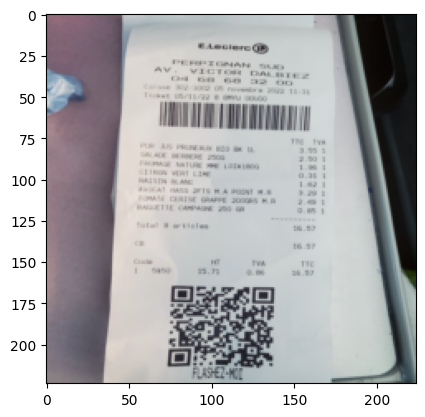

In [74]:
from matplotlib import pyplot as plt

plt.imshow(encoding['image'].permute(1, 2, 0))

In [75]:
encoding['bbox'][1] / 1000 * 224

tensor([ 92.0640, 200.7040, 124.0960, 205.1840])

In [76]:
encoding['labels'][1]

tensor(1)

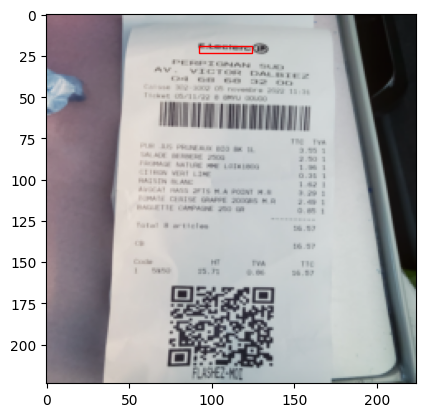

In [77]:
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(encoding['image'].permute(1, 2, 0))

# Create a Rectangle patch
resized_bbox = encoding['bbox'][1] / 1000 * 224
rect = patches.Rectangle((resized_bbox[0], 224 - resized_bbox[3]), resized_bbox[2] - resized_bbox[0], resized_bbox[3] - resized_bbox[1], 
                         linewidth=1,
                         edgecolor='r',
                         facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

Test entraînement

In [78]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] e. leclerc l 05 novembre 2022 3. 55 1 2. 50 1 1. 96 1 0. 31 1 1. 62 1 3. 29 1 2. 49 1 0. 85 1 16. 57 pur jus pruneaux bio bk 1l salade berbere 250g fromage nature mme loik180g citron vert lime raisin blanc avocat hass 2fts m. a point m. r tomate cerise grappe 200grs m. r baguette campagne 250 gr 5 % 50 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [79]:
train_formatted_annotations[0][0]

['E.Leclerc',
 'L',
 '05',
 'novembre',
 '2022',
 '3.55',
 '1',
 '2.50',
 '1',
 '1.96',
 '1',
 '0.31',
 '1',
 '1.62',
 '1',
 '3.29',
 '1',
 '2.49',
 '1',
 '0.85',
 '1',
 '16.57',
 'PUR',
 'JUS',
 'PRUNEAUX',
 'BIO',
 'BK',
 '1L',
 'SALADE',
 'BERBERE',
 '250G',
 'FROMAGE',
 'NATURE',
 'MME',
 'LOIK180G',
 'CITRON',
 'VERT',
 'LIME',
 'RAISIN',
 'BLANC',
 'AVOCAT',
 'HASS',
 '2FTS',
 'M.A',
 'POINT',
 'M.R',
 'TOMATE',
 'CERISE',
 'GRAPPE',
 '200GRS',
 'M.R',
 'BAGUETTE',
 'CAMPAGNE',
 '250',
 'GR',
 '5%50']

In [80]:
train_formatted_annotations[1][0]

['magasin',
 'magasin',
 'date',
 'date',
 'date',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'total_price',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'taux_tva']

In [81]:
[id2label[label] for label in encoding['labels'].tolist() if label != -100]

['magasin',
 'magasin',
 'date',
 'date',
 'date',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'item_total_price',
 'item_quantity',
 'total_price',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'item_name',
 'taux_tva']

In [82]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
    print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
e 1
. -100
le -100
##cle -100
##rc -100
l 1
05 6
nov 6
##em -100
##bre -100
202 6
##2 -100
3 2
. -100
55 -100
1 5
2 2
. -100
50 -100
1 5
1 2
. -100
96 -100
1 5
0 2
. -100
31 -100
1 5
1 2


Création de DataLoaders

In [83]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

Entraînement

In [84]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                         num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4

# Put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss

        # print loss every 100 steps
        if global_step % 100 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.16.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.5.conv2.norm.num_batches_tr

Epoch: 0


/opt/mamba/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/17 [00:00<?, ?it/s]

Loss after 0 steps: 2.206742525100708
Epoch: 1


  0%|          | 0/17 [00:00<?, ?it/s]